In [ ]:
# DBD (Dielectric Barrier Discharge) toy simulation for teaching
# - Series C_g (gas) and C_d (dielectric)
# - Sinusoidal drive V_a(t) = V0 * sin(2π f t)
# - When |E_g| = |V_g|/d_g ≥ E_br, trigger a "microdischarge" event that instantaneously adds charge
#   ΔQ = sign(V_g) * q_event onto the dielectric (raising V_d and reducing V_g).
# - Plot Lissajous (Q vs V) and estimate power from the loop area.
#
# Notes:
# * This is a pedagogical toy model—simple, stable, and tunable for the classroom.
# * The discrete-time detection slightly oversteps the exact breakdown instant; keep dt small for nicer loops.
# * You can tweak q_event for "fatter" loops and f/V0/E_br for discharge frequency.
#
# HOW TO USE:
# - Change the PARAMETERS block (V0, f, r, d_b, d_g, eps_r, q_event, E_br).
# - Re-run the cell to show how the Lissajous and power change.
# - The printed table summarizes the effective capacitances and the computed power.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# ------------------- PARAMETERS (tweak here) -------------------
V0      = 6000.0       # Peak drive voltage [V]
f       = 10000.0      # Drive frequency [Hz]
cycles  = 6            # Simulate N cycles (last cycle used for power)
E_br    = 3.0e6        # Air breakdown field [V/m]  (~30 kV/cm)
r       = 2.5e-4       # Microdischarge "cell" radius [m] (0.25 mm)
d_b     = 5.0e-4       # Dielectric thickness [m]   (0.5 mm)
eps_r   = 5.0          # Relative permittivity of dielectric (e.g., glass ~ 5-7)
d_g     = 1.0e-3       # Gas gap thickness [m]      (1.0 mm)

q_event = 1.0e-11      # Charge added per microdischarge event [C] (~10 pC)
dt_per_period = 4000   # Time resolution: # steps per period (↑ for smoother detection)
seed    = 0            # RNG seed (unused here, reserved for future extensions)
# ---------------------------------------------------------------

np.random.seed(seed)

# Derived quantities
eps0  = 8.8541878128e-12
A     = pi * r**2
C_d   = eps0 * eps_r * A / d_b             # dielectric capacitance of the "cell"
C_g   = eps0 * A / d_g                      # gas-gap capacitance (no discharge)
C_eq  = (C_d * C_g) / (C_d + C_g)           # series capacitance (no discharge)
w     = 2.0 * pi * f
T     = 1.0 / f
dt    = T / dt_per_period
N     = int(np.round(cycles * T / dt))
V_br  = E_br * d_g                           # voltage threshold across the gas gap

# Storage
t_arr   = np.zeros(N+1)
Va_arr  = np.zeros(N+1)   # applied voltage
Q_arr   = np.zeros(N+1)   # charge that has flowed in external circuit (on C_d)
Vd_arr  = np.zeros(N+1)   # dielectric voltage
Vg_arr  = np.zeros(N+1)   # gas voltage
Eg_arr  = np.zeros(N+1)   # gas field
events_t = []
events_dQ = []

# Initial conditions
t = 0.0
Va = V0 * np.sin(w * t)
Q  = 0.0

# Record t=0
t_arr[0]  = t
Va_arr[0] = Va
Vd        = Q / C_d if C_d > 0 else 0.0
Vg        = Va - Vd
Vd_arr[0] = Vd
Vg_arr[0] = Vg
Eg_arr[0] = Vg / d_g

# Main loop
max_loops = 100  # safety to avoid infinite while during a time step
for i in range(N):
    # Advance drive voltage by displacement only (no conduction across gas)
    t_next = (i+1) * dt
    Va_next = V0 * np.sin(w * t_next)
    dVa = Va_next - Va
    Q += C_eq * dVa  # displacement current through the series C_g || C_d path

    # Update voltages
    Vd = Q / C_d if C_d > 0 else 0.0
    Vg = Va_next - Vd

    # Microdischarge events (instantaneous jumps in Q)
    guard = 0
    while abs(Vg) >= V_br and guard < max_loops:
        dQ_event = np.sign(Vg) * q_event   # add charge with the same sign as Vg to oppose it
        Q += dQ_event
        events_t.append(t_next)
        events_dQ.append(dQ_event)

        Vd = Q / C_d if C_d > 0 else 0.0
        Vg = Va_next - Vd
        guard += 1

    # Commit state
    t = t_next
    Va = Va_next

    t_arr[i+1]  = t
    Va_arr[i+1] = Va
    Q_arr[i+1]  = Q
    Vd_arr[i+1] = Vd
    Vg_arr[i+1] = Vg
    Eg_arr[i+1] = Vg / d_g

# ----- Lissajous figure (Q vs Va) -----
# Use the last full cycle for area (energy per cycle): W = ∮ V dQ (trapezoid rule)
# Identify indices for the last cycle
start_idx = N - dt_per_period
if start_idx < 0:
    start_idx = 0
Va_last = Va_arr[start_idx:]
Q_last  = Q_arr[start_idx:]
# Trapezoidal line integral ∮ V dQ over that cycle
W_cycle = np.sum(0.5 * (Va_last[:-1] + Va_last[1:]) * (Q_last[1:] - Q_last[:-1]))
P_avg = f * W_cycle  # average power

# ---- Summaries to help teaching ----
summary = pd.DataFrame(
    {
        "Parameter": [
            "Drive amplitude (V0) [V]",
            "Frequency (f) [Hz]",
            "Period (T) [s]",
            "Cell area (A) [m^2]",
            "Dielectric thickness (d_b) [m]",
            "Gas gap (d_g) [m]",
            "Relative permittivity (eps_r) [-]",
            "C_d [F]",
            "C_g [F]",
            "C_series (no discharge) [F]",
            "E_br [V/m]",
            "V_br = E_br * d_g [V]",
            "q_event per microdischarge [C]",
            "# microdischarges (total) [-]",
            "Energy per last cycle (W_cycle) [J]",
            "Average power (P_avg) [W]",
        ],
        "Value": [
            V0,
            f,
            T,
            A,
            d_b,
            d_g,
            eps_r,
            C_d,
            C_g,
            C_eq,
            E_br,
            V_br,
            q_event,
            len(events_t),
            W_cycle,
            P_avg,
        ],
    }
)

print("DBD simulation summary", summary)


DBD simulation summary                               Parameter         Value
0              Drive amplitude (V0) [V]  6.000000e+03
1                    Frequency (f) [Hz]  1.000000e+04
2                        Period (T) [s]  1.000000e-04
3                   Cell area (A) [m^2]  1.963495e-07
4        Dielectric thickness (d_b) [m]  5.000000e-04
5                     Gas gap (d_g) [m]  1.000000e-03
6     Relative permittivity (eps_r) [-]  5.000000e+00
7                               C_d [F]  1.738516e-14
8                               C_g [F]  1.738516e-15
9           C_series (no discharge) [F]  1.580469e-15
10                           E_br [V/m]  3.000000e+06
11                V_br = E_br * d_g [V]  3.000000e+03
12       q_event per microdischarge [C]  1.000000e-11
13        # microdischarges (total) [-]  1.150000e+02
14  Energy per last cycle (W_cycle) [J]  5.968900e-07
15            Average power (P_avg) [W]  5.968900e-03


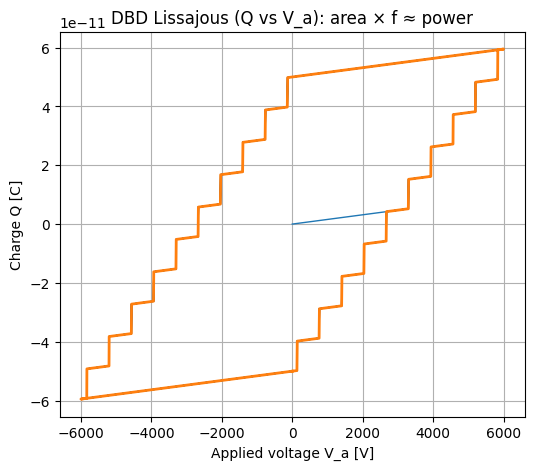

In [18]:


# ----- PLOTS -----
# 1) Lissajous: Q vs V_a (last cycle emphasized)
plt.figure(figsize=(6, 5))
plt.plot(Va_arr, Q_arr, lw=1)
plt.plot(Va_last, Q_last, lw=2)  # highlight last cycle
plt.xlabel("Applied voltage V_a [V]")
plt.ylabel("Charge Q [C]")
plt.title("DBD Lissajous (Q vs V_a): area × f ≈ power")
plt.grid(True)
plt.show()


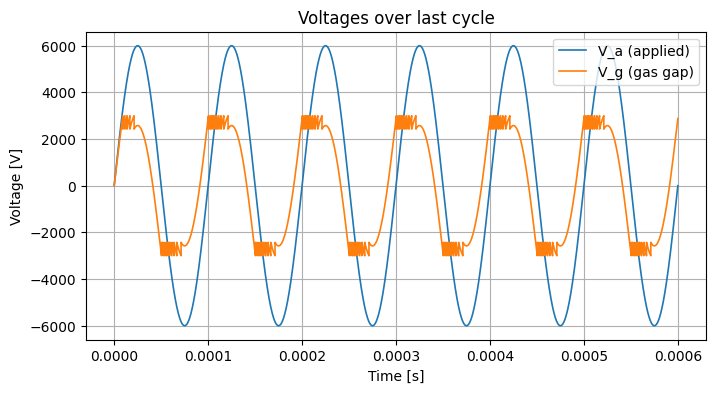

In [20]:

# 2) Time traces: V_a and V_g over the last cycle
plt.figure(figsize=(8, 4))
start_idx=1
t_last = t_arr[start_idx:]
plt.plot(t_last, Va_arr[start_idx:], label="V_a (applied)", lw=1.2)
plt.plot(t_last, Vg_arr[start_idx:], label="V_g (gas gap)", lw=1.2)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.title("Voltages over last cycle")
plt.legend()
plt.grid(True)
plt.show()


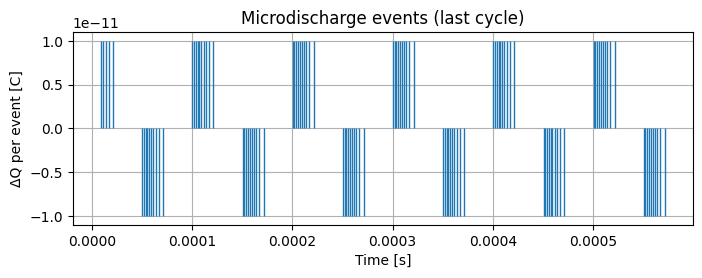

In [ ]:

# 3) Optional: stick plot of microdischarge events in the last cycle
events_in_last = [(tt, dqq) for tt, dqq in zip(events_t, events_dQ) if tt >= t_arr[start_idx]]
if len(events_in_last) > 0:
    ev_t = np.array([e[0] for e in events_in_last])
    ev_q = np.array([e[1] for e in events_in_last])
    plt.figure(figsize=(8, 2.5))
    # Simple impulse visualization: vertical lines with height proportional to ΔQ
    for (tt, dqq) in events_in_last:
        plt.vlines(tt, 0, dqq, linewidth=1)
    plt.xlabel("Time [s]")
    plt.ylabel("ΔQ per event [C]")
    plt.title("Microdischarge events (last cycle)")
    plt.grid(True)
    plt.show()

